<h1><center><b>SPORTS PERSON CLASSIFIER MODEL.</center></h1>

### A Machine learning model that identifies sports personalities from images using OpenCV-based face detection and wavelet feature extraction.


## Tools and Libraries used:
- **Python**
- **OpenCV**
- **Scikit-learn**
- **NumPy**
- **Matplotlib**

### Approach
- Face and eye detection using Haar cascades
- Feature extraction using Wavelet Transform
- Model training using SVM, Logistic Regression, and Random Forest
- Hyperparameter tuning using GridSearchCV



In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Preprocessing: Detecting face and eyes

### Will Use haar cascade from opencv to detect face and eyes.

In [2]:
img = cv2.imread("test_images/alisha.jpg")
img.shape

(552, 828, 3)

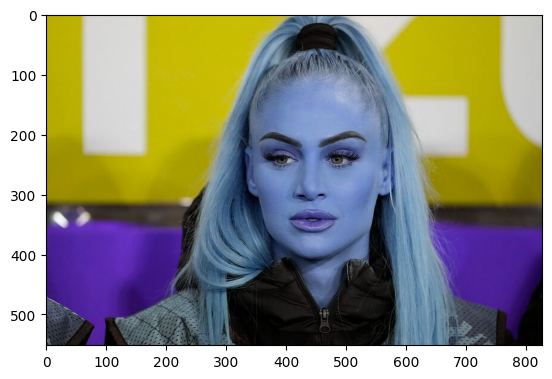

In [3]:
plt.imshow(img)

#### Converting the image from coloured to greyscale for faster processing.

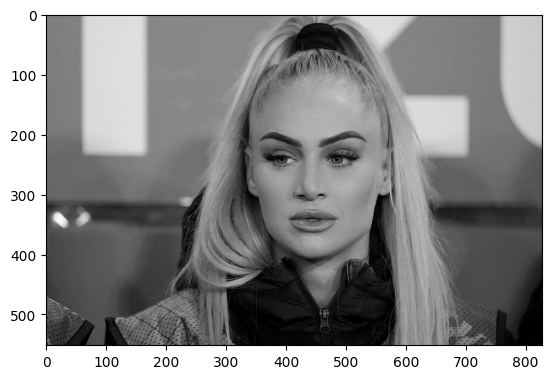

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

#### Loading pre trained Haar cascade classifiers for detecting faces and eyes. These XML files help OpenCV identify facial features.

In [5]:
face_cascade = cv2.CascadeClassifier('../server/opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../server/opencv/haarcascades/haarcascade_eye.xml')

### Detecting face for an image and Drawing a square on face

In [6]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5) # (image, scale factor, MinNeighbors)
faces

array([[302, 122, 282, 282]], dtype=int32)

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(np.int32(302), np.int32(122), np.int32(282), np.int32(282))

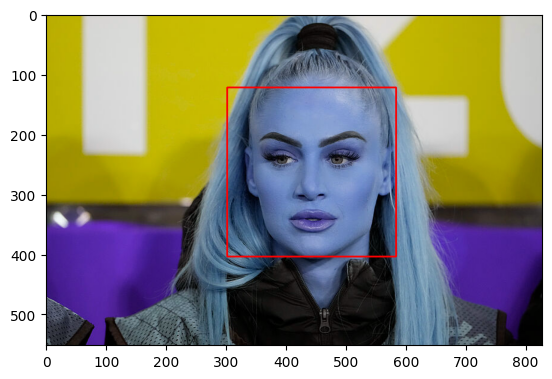

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)   # (image, (x1,y1), (x2, y2), color, thickness)
plt.imshow(face_img)

#### Drawing bounding boxes, and detecting eyes within face region. And Croping the facial region of the image, remaining part is not important

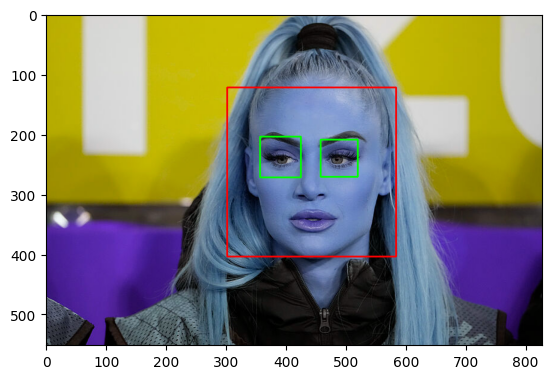

In [9]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
plt.imshow(face_img, cmap='gray')

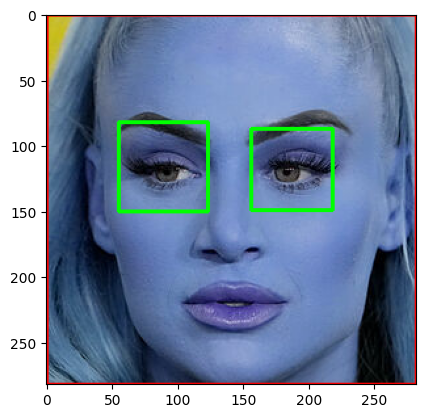

In [10]:
%matplotlib inline
plt.imshow(roi_color)

In [11]:
cropped_img = np.array(roi_color)
cropped_img.shape

(282, 282, 3)

### Using wavelet transform as a feature for traning our model</h3>

#### Wavelet transforms help capture high-frequency facial details such as edges and contours. Combining raw pixel values with wavelet features improves the model’s ability to distinguish between facial structures.

 In short in wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc


In [12]:
# import numpy as np
import pywt
import cv2    
    
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    # Computing coefficients (Wavelet Decomposition)
    # for 2d image, WaveletDecomposition returns c[0], c[1], c[2], c[3]
    # cA(approximated coeff's),  cH(horizontal details),  cV(vertical details),  cD(Diagonal details)
    coeffs = pywt.wavedec2(imArray, mode, level=level)  
                        
    #Processing Coefficients
    coeffs_H = list(coeffs)  
    coeffs_H[0] *= 0;    # Approximated coeff's not required, hence zeroed.
                  
    # Reconstruction, using remaining coeff's.
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
                
    return imArray_H

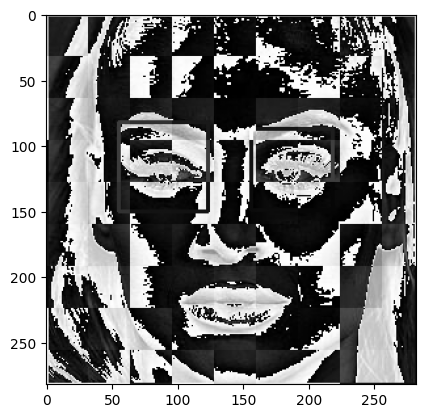

In [13]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

### Loading image, detecting face. If eyes >=2, then save and crop the face region</h3>

In [14]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

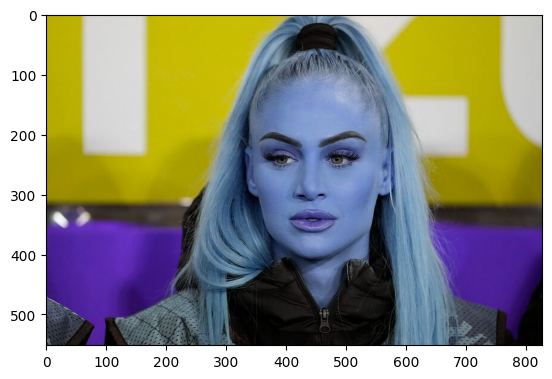

In [15]:
original_image = cv2.imread("test_images/alisha.jpg")
plt.imshow(original_image)

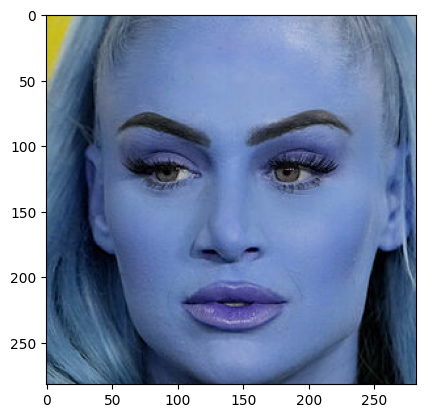

In [16]:
cropped_image = get_cropped_image_if_2_eyes("test_images/alisha.jpg")
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

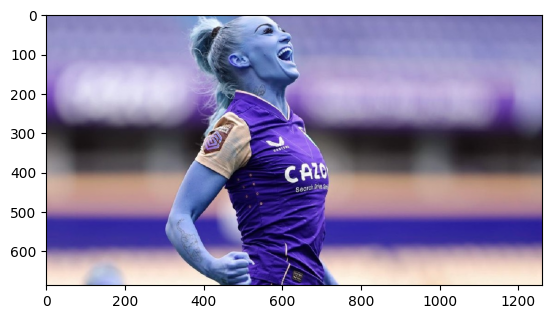

In [17]:
org_image_obstructed = cv2.imread('test_images/alisha2.jpg')
plt.imshow(org_image_obstructed)

In [18]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('test_images/alisha2.jpg')
cropped_image_no_2_eyes

**Above 'cropped_image_no_2_eyes' is None which means we should ignore this image and we will not use such image for model training**

In [19]:
path_to_data = "dataset/"
path_to_cr_data = "dataset/cropped/"

### Saving paths of directories having all images

In [20]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [21]:
img_dirs

['dataset/alisha_lehmann',
 'dataset/christiano_ronaldo',
 'dataset/cropped',
 'dataset/lionel_messi',
 'dataset/maria_sharapova',
 'dataset/virat_kohli']

### **Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [22]:
# deleting the existing ./dataset/cropped/ folder (if it exists) and recreating it as an empty directory.
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

This below code creates a cropped folder 


In [23]:
valid_extensions = (".jpg", ".jpeg", ".png")

cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        # Skip non-files and non-images
        if not entry.is_file() or not entry.name.lower().endswith(valid_extensions):
            continue

        roi_color = get_cropped_image_if_2_eyes(entry.path)

        if roi_color is not None:
            cropped_folder = os.path.join(path_to_cr_data, celebrity_name)

            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder:", cropped_folder)
 
            cropped_file_name = f"{celebrity_name}{count}.png"
            cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                                          
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1


Generating cropped images in folder: dataset/cropped/alisha_lehmann
Generating cropped images in folder: dataset/cropped/christiano_ronaldo
Generating cropped images in folder: dataset/cropped/lionel_messi
Generating cropped images in folder: dataset/cropped/maria_sharapova
Generating cropped images in folder: dataset/cropped/virat_kohli


### Creating a dictionary mapping each subfolder name (celebrity) to a list of full paths of their cropped image files.

In [24]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'alisha_lehmann': ['dataset/cropped/alisha_lehmann\\alisha_lehmann1.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann10.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann11.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann12.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann13.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann14.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann15.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann16.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann17.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann18.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann19.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann2.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann20.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann21.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann22.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann23.png',
  'dataset/cropped/alisha_lehmann\\alisha_lehmann24.png'

In [25]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'alisha_lehmann': 0,
 'christiano_ronaldo': 1,
 'lionel_messi': 2,
 'maria_sharapova': 3,
 'virat_kohli': 4}

### Images in cropped folder will be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Now Let's prepare X and y.

### Wavelet transformation is used to exctract facial features from data for identification

In [26]:
 X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [27]:
len(X[0])

4096

In [28]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(192, 4096)

In [29]:
# To delete doubly downloaded files:
# import os

# folder_path = r"C:\Users\Dell\cfr\model\dataset\alisha_lehmann"

# for filename in os.listdir(folder_path):
#     if "(1)" in filename:
#         file_path = os.path.join(folder_path, filename)
#         print(f"Deleting: {file_path}")
#         os.remove(file_path)

## Data cleaning process is done. Now we are ready to train our model

#### We will use SVM with rbf kernel tuned  with heuristic finetuning

In [30]:
from sklearn.svm import SVC # Support Vector Classifier.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

### Normalizing data and training an SVM Classifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
# Standard Scalar is used to clean/normalize data.
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6458333333333334

In [32]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.54      0.93      0.68        14
           1       0.80      0.50      0.62         8
           2       0.62      0.50      0.56        10
           3       0.00      0.00      0.00         5
           4       0.82      0.82      0.82        11

    accuracy                           0.65        48
   macro avg       0.56      0.55      0.53        48
weighted avg       0.61      0.65      0.61        48



C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Using GridSearch to try out different models with different parameters. Our Goal is to come up with best model with best fine tuned parameters.

In [33]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [34]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [0.1, 1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}    

#### Now Running model selection and hyperparameter tuning using cross-validation, then storing results in a dataframe for comparison.

In [35]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df



,model,best_score,best_params
0,svm,0.812562,"{'svc__C': 0.1, 'svc__kernel': 'linear'}"
1,random_forest,0.632266,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.763793,{'logisticregression__C': 1}


In [36]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=0.1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [37]:
best_estimators['svm'].score(X_test,y_test)

0.6875

In [38]:
best_estimators['random_forest'].score(X_test,y_test)

0.625

In [39]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.75

In [40]:
best_clf = best_estimators['logistic_regression']

#### The dataset is relatively small and imbalanced across classes, which limits overall accuracy. 
#### The goal of this project is to demonstrate the complete computer vision pipeline rather than achieve production-level performance.


In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[12,  1,  1,  0,  0],
       [ 1,  7,  0,  0,  0],
       [ 0,  0,  6,  2,  2],
       [ 4,  0,  0,  1,  0],
       [ 1,  0,  0,  0, 10]])

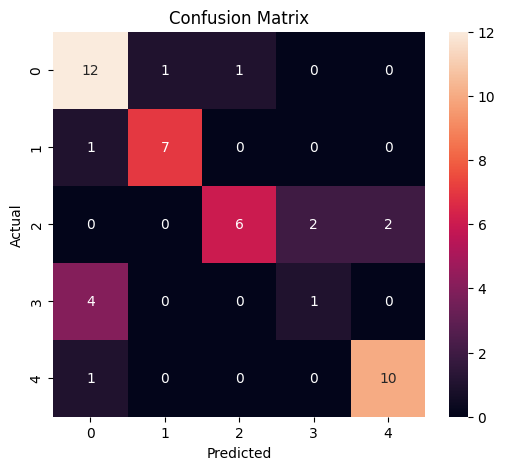

In [42]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [43]:
class_dict

{'alisha_lehmann': 0,
 'christiano_ronaldo': 1,
 'lionel_messi': 2,
 'maria_sharapova': 3,
 'virat_kohli': 4}

### Saving the trained model

In [44]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Saving class dictionary

In [45]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))